# NBA Prediction Model

**NOTE: DUE TO API LIMITATION, IT IS NOT RECOMMENDED TO RUN THE SECTIONS "EXTRACTING DATA FROM API" AS SOME CELLS MIGHT TAKE UP TO 6 HOURS TO RUN. PLEASE USE THE BELOW LINKS TO DOWNLOAD THE DATASETS:**
* <a href="https://www.dropbox.com/s/95cit7k0jj3zlq5/boxscore_master.csv?dl=0">BOXSCORE MASTER</a> 
* <a href="https://www.dropbox.com/s/b6fx8fta4rpc520/League_game_log_master.csv?dl=0">LEAGUE GAMELOG MASTER</a>
* <a href="https://www.dropbox.com/s/pfkb7qisjwziipe/players_log_master.csv?dl=0">PLAYER LOG MASTER</a>
* <a href="https://www.dropbox.com/s/fi62lmumdqv366g/team_master.csv?dl=0">TEAM MASTER</a>


## Introduction

Statistics have revolutionized the game of basketball, more specifically the NBA (Ross, 2015). With a lot of teams relying heavily on statistic to make decisions in style of play, changes and aquisitions. For this reason, we decided to take advantage of those available stats and create a model that can be benefitial in terms of application. Our notebook is going to be in two parts. In the first part, we are going to predict the number of field goals made (scored shots) by a player by using historic data of active players in the league. in the second part, we are going to predict the outcome of a game by training our model on data from half-time of previous games. For this notebook, we have found an API that is built on top of the official NBA stats API but with proper documentation. Documenation of the API can be found on this <a href="https://github.com/swar/nba_api">link</a>.

Before we start, let's import all the libraries we are going to use in our model.

In [149]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.endpoints import boxscoretraditionalv2
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.static import teams
from nba_api.stats.library.parameters import SeasonAll
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats.stats import pearsonr
import requests
import math
import pandas as pd
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Part 1: NBA Field Goal Predictive Model

The purpose behind this section is to build a model that predicts the number of field goals made (shots scored) by a player in upcoming games. In a real world application, a team can use this model and predict those field goals and try to improve the performance of their players based on the outcome of the model.  

## Datasets aquisition from API

**NOTE: THE FOLLOWING SECTION TAKES UP TO TWO HOURS TO RUN DUE TO API LIMITATION, IT IS ADVISABLE NOT TO RUN IT UNLESS IT IS NECESSARY. PLEASE DOWNLOAD THE DATASETS FROM THE LINK PROVIDED AT THE TOP OF THE PAGE AND GO TO FEATURE ENGINEERING SECTION**

First, we create a list of currently active players in the league from the players <a href="https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/static/players.md">endpoint</a> in the API. Then, we store the response data in a dictionary so we can create a list of ID's based on those data.

In [2]:
players_dict = players.get_active_players()
players_dict

[{'id': 203500,
  'full_name': 'Steven Adams',
  'first_name': 'Steven',
  'last_name': 'Adams',
  'is_active': True},
 {'id': 1628389,
  'full_name': 'Bam Adebayo',
  'first_name': 'Bam',
  'last_name': 'Adebayo',
  'is_active': True},
 {'id': 200746,
  'full_name': 'LaMarcus Aldridge',
  'first_name': 'LaMarcus',
  'last_name': 'Aldridge',
  'is_active': True},
 {'id': 1629734,
  'full_name': 'Kyle Alexander',
  'first_name': 'Kyle',
  'last_name': 'Alexander',
  'is_active': True},
 {'id': 1629638,
  'full_name': 'Nickeil Alexander-Walker',
  'first_name': 'Nickeil',
  'last_name': 'Alexander-Walker',
  'is_active': True},
 {'id': 1628960,
  'full_name': 'Grayson Allen',
  'first_name': 'Grayson',
  'last_name': 'Allen',
  'is_active': True},
 {'id': 1628386,
  'full_name': 'Jarrett Allen',
  'first_name': 'Jarrett',
  'last_name': 'Allen',
  'is_active': True},
 {'id': 1628443,
  'full_name': 'Kadeem Allen',
  'first_name': 'Kadeem',
  'last_name': 'Allen',
  'is_active': True},
 {

In [3]:
id_list = []
for player in players_dict:
    id_list.append(str(player["id"]))
len(id_list)

519

We now see that we have 519 active players in the league. Now, we get data from <a href="https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md">Player Game Log Endpoint</a>. Due to API limitations, we had to create two loops and insert some sleep commands in order to fetch the data properly without errors. Once done, we store it in a CSV for later use.

In [16]:
df_playerslog_master = playersgamelog.PlayerGameLog(player_id = id_list[0], season = SeasonAll.all ,timeout=5).get_data_frames()[0]
id_list.pop(0)
df_playerslog_master.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22020,203500,0022000126,"JAN 08, 2021",NOP vs. CHA,L,35,5,7,0.714,...,6,7,2,1,2,4,3,13,-4,1
1,22020,203500,0022000114,"JAN 06, 2021",NOP vs. OKC,L,34,4,5,0.800,...,9,11,10,1,0,2,2,10,4,1
2,22020,203500,0022000100,"JAN 04, 2021",NOP vs. IND,L,31,4,7,0.571,...,4,8,0,3,0,4,5,10,5,1
3,22020,203500,0022000084,"JAN 02, 2021",NOP vs. TOR,W,31,4,7,0.571,...,6,10,1,2,0,3,2,13,4,1
4,22020,203500,0022000067,"DEC 31, 2020",NOP @ OKC,W,31,7,13,0.538,...,4,10,2,1,1,0,1,14,15,1


In [17]:
# creating two loops and two counters to perform sleep command after a certain number of calls.
# using Try Catch approach to avoid HTTP Request Timeout Error
counter = 0

itirator = 0
try:
    
    while len(id_list) > 0:
        itirator +=1
        
        for i in range(0,15):
            if len(id_list) == 0: 
                print("Fetching players data completed")
                break
                
            if i < len(id_list):
                
                
                df_temp = playersgamelog.PlayerGameLog(player_id = id_list[i], season = SeasonAll.all, timeout=10).get_data_frames()[0]
                df_playerslog_master = pd.concat([df_playerslog_master, df_temp], axis = 0)
            
            elif i > len(id_list):
                
                for j in range(0, len(id_list)):
                    
                    df_temp = playersgamelog.PlayerGameLog(player_id = id_list[j], season = SeasonAll.all, timeout=10).get_data_frames()[0]
                    df_playerslog_master = pd.concat([df_playerslog_master, df_temp], axis = 0)
                break
                
            counter+=1
            if counter == 10:
                time.sleep(2)
                counter = 0
        for i in range(0,15):
            if len(id_list) == 0: 
                print("Fetching players data completed")
                break
            id_list.pop(0)
        print("itirating through the itiratoin number", itirator,"and now pausing for 20 seconds")
        print("Remaining Players id to fetch", len(id_list))
        time.sleep(20)
except requests.exceptions.Timeout:
    print("A timeout error has occured")
    print("Remaining players", len(id_list))
df_playerlog_master.to_csv("players_log_master.csv")

itirating through the itiratoin number 1 and now pausing for 20 seconds
Remaining Players id to fetch 503
itirating through the itiratoin number 2 and now pausing for 20 seconds
Remaining Players id to fetch 488
itirating through the itiratoin number 3 and now pausing for 20 seconds
Remaining Players id to fetch 473
itirating through the itiratoin number 4 and now pausing for 20 seconds
Remaining Players id to fetch 458
itirating through the itiratoin number 5 and now pausing for 20 seconds
Remaining Players id to fetch 443
itirating through the itiratoin number 6 and now pausing for 20 seconds
Remaining Players id to fetch 428
itirating through the itiratoin number 7 and now pausing for 20 seconds
Remaining Players id to fetch 413
itirating through the itiratoin number 8 and now pausing for 20 seconds
Remaining Players id to fetch 398
itirating through the itiratoin number 9 and now pausing for 20 seconds
Remaining Players id to fetch 383
itirating through the itiratoin number 10 and 

In [10]:
df_playerslog_master = pd.read_csv("players_log_master.csv")
df_playerslog_master.head()

,Unnamed: 0,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,0,22020,203500,22000126,"JAN 08, 2021",NOP vs. CHA,L,35,5,7,...,6,7.0,2,1,2,4,3,13,-4,1
1,1,22020,203500,22000114,"JAN 06, 2021",NOP vs. OKC,L,34,4,5,...,9,11.0,10,1,0,2,2,10,4,1
2,2,22020,203500,22000100,"JAN 04, 2021",NOP vs. IND,L,31,4,7,...,4,8.0,0,3,0,4,5,10,5,1
3,3,22020,203500,22000084,"JAN 02, 2021",NOP vs. TOR,W,31,4,7,...,6,10.0,1,2,0,3,2,13,4,1
4,4,22020,203500,22000067,"DEC 31, 2020",NOP @ OKC,W,31,7,13,...,4,10.0,2,1,1,0,1,14,15,1


**player_log_master** basically is a log where we have every game stats for every active player in the league. But after analyzing the data, we noticed that some important features are missing such as the position of a player with a specific team. Therefor we are going to use the commonteamroster endpoint and get the missing variables. 

We create a unique list of seasons every player have played in our dataset and a list of ID's of every team in the league. In here we use also the <a href="https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/static/teams.md">Team Static Endpoint</a> to get the Team ID's 

In [11]:

def clean_season_id(x):
         return x[1:]

seasons_list = pd.DataFrame(df_playerslog_master["SEASON_ID"].astype(str))
seasons_list = seasons_list.sort_values(by="SEASON_ID", ascending= True)
seasons_list["SEASON_ID"] = seasons_list["SEASON_ID"].apply(clean_season_id)
seasons_list = seasons_list["SEASON_ID"].unique().tolist()
print(seasons_list)

['1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']


In [12]:
team_id_list = []
team_dict = teams.get_teams()
for teams in team_dict:
    team_id_list.append(teams["id"])
print(team_id_list)

[1610612737, 1610612738, 1610612739, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]


Now that we have the necessary parameters we need to pass to the API, we create an empty dataframe with the same structure. We can do so by requesting data with one parameter from <a href="https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/commonteamroster.md">Common Team Roster Endpoint</a> and then dropping all the entries. Once done, we end up with an empty table but with the same structure as the desired dataframe.

In [26]:
df_team_master = commonteamroster.CommonTeamRoster(team_id = team_id_list[0], season= seasons_list[0], timeout=10).get_data_frames()[0]
df_team_master = df_team_master.drop([0,1,2,3,4,5,6,7,8,9,10], axis = 0)
df_team_master

,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID


In [27]:
counter = 0
for seasons in seasons_list:
    print("fetching data for season", seasons)
    for team_id in team_id_list:
        df_temp = commonteamroster.CommonTeamRoster(team_id = team_id, season= seasons, timeout=10).get_data_frames()[0]
        df_team_master = pd.concat([df_team_master, df_temp], axis = 0)
        counter += 1
        if counter == 3:
            time.sleep(3)
            counter = 0
    print("Data recieved for all teams in season", seasons, ". Now pausing for 20 seconds")
    time.sleep(20)

df_team_master.to_csv("team_master.csv")

fetching data for season 1998
Data recieved for all teams in season 1998 . Now pausing for 20 seconds
fetching data for season 1999
Data recieved for all teams in season 1999 . Now pausing for 20 seconds
fetching data for season 2000
Data recieved for all teams in season 2000 . Now pausing for 20 seconds
fetching data for season 2001
Data recieved for all teams in season 2001 . Now pausing for 20 seconds
fetching data for season 2002
Data recieved for all teams in season 2002 . Now pausing for 20 seconds
fetching data for season 2003
Data recieved for all teams in season 2003 . Now pausing for 20 seconds
fetching data for season 2004
Data recieved for all teams in season 2004 . Now pausing for 20 seconds
fetching data for season 2005
Data recieved for all teams in season 2005 . Now pausing for 20 seconds
fetching data for season 2006
Data recieved for all teams in season 2006 . Now pausing for 20 seconds
fetching data for season 2007
Data recieved for all teams in season 2007 . Now pau

In [13]:
df_team_master = pd.read_csv("team_master.csv")
df_team_master

,Unnamed: 0,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID
0,0,1610612737,1998,0,Chris Crawford,chris-crawford,4,F,6-9,235,"MAY 13, 1975",24.0,1,Marquette,1544
1,1,1610612737,1998,0,Roshown McLeod,roshown-mcleod,7,F,6-8,220,"NOV 17, 1975",23.0,R,Duke,1728
2,2,1610612737,1998,0,Steven Smith,steven-smith,8,G,6-8,215,"MAR 31, 1969",30.0,7,Michigan State,120
3,3,1610612737,1998,0,Mookie Blaylock,mookie-blaylock,10,G,6-1,185,"MAR 20, 1967",32.0,9,Oklahoma,302
4,4,1610612737,1998,0,Ed Gray,ed-gray,22,G,6-3,210,"SEP 27, 1975",23.0,1,California,1516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9943,11,1610612766,2020,0,Gordon Hayward,gordon-hayward,20,F,6-7,225,"MAR 23, 1990",30.0,10,Butler,202330
9944,12,1610612766,2020,0,Vernon Carey Jr.,vernon-carey-jr,22,F-C,6-10,270,"FEB 25, 2001",19.0,R,Duke,1630176
9945,13,1610612766,2020,0,P.J. Washington,pj-washington,25,F,6-7,230,"AUG 23, 1998",22.0,1,Kentucky,1629023
9946,14,1610612766,2020,0,Nate Darling,nate-darling,30,G,6-5,200,"AUG 30, 1998",22.0,R,Delaware,1630268


Now that we have everything ready, we can proceed with the feature engineering part.

## Feature engineering

In this section, we are going to look combine dataframes saved earlier so we can end up with a dataset for our model.

We noticed that the playerlog dataframe is missing some key values such the players team name, position he played on that team and the player name. In order to do so, we start by changing some column names so they can match eachother and have a proper key to perform a merge. before we start we're going to explain what every dataframe means.

Players log is a dataframe that contains statistics of every game played by active players in the league. Team master dataframe contains the roster of every team on a specific season and finally the team dataframe contains basic information about every team in the league.

In [4]:
# Loading datasets into dfs
df_team_master = pd.read_csv("team_master.csv")
df_playerslog_master = pd.read_csv("players_log_master.csv")

In [5]:
# creating a dataframe from teams dictionary
team_dict = teams.get_teams()
teams_df = pd.DataFrame(team_dict)
# changing column names so they can match other dataframes and have a proper naming schema
teams_df = teams_df.rename(columns={
    "id" : "TeamID", "full_name" : "TEAM_FULL_NAME", "abbreviation" : "TEAM_ABBREVIATION"
})
teams_df.head()


,TeamID,TEAM_FULL_NAME,TEAM_ABBREVIATION,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [6]:
# merging team master dataframe and teams dataframe so we can get the full name of the team and the abbriviation
df_team_master = pd.merge(df_team_master, teams_df[["TeamID","TEAM_FULL_NAME", "TEAM_ABBREVIATION"]], how = "left",on="TeamID")
# dropping Unnamed column
df_team_master.drop(['Unnamed: 0'], axis = 1,inplace=True)
# changing player to player full name to have a proper naming schema 
df_team_master = df_team_master.rename(columns= {"PLAYER":"PLAYER_FULL_NAME"})
df_team_master.head()

,TeamID,SEASON,LeagueID,PLAYER_FULL_NAME,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,TEAM_FULL_NAME,TEAM_ABBREVIATION
0,1610612737,1998,0,Chris Crawford,chris-crawford,4,F,6-9,235,"MAY 13, 1975",24.0,1,Marquette,1544,Atlanta Hawks,ATL
1,1610612737,1998,0,Roshown McLeod,roshown-mcleod,7,F,6-8,220,"NOV 17, 1975",23.0,R,Duke,1728,Atlanta Hawks,ATL
2,1610612737,1998,0,Steven Smith,steven-smith,8,G,6-8,215,"MAR 31, 1969",30.0,7,Michigan State,120,Atlanta Hawks,ATL
3,1610612737,1998,0,Mookie Blaylock,mookie-blaylock,10,G,6-1,185,"MAR 20, 1967",32.0,9,Oklahoma,302,Atlanta Hawks,ATL
4,1610612737,1998,0,Ed Gray,ed-gray,22,G,6-3,210,"SEP 27, 1975",23.0,1,California,1516,Atlanta Hawks,ATL


In [8]:
# creating a dataframe from players dictionary
players_dict = players.get_active_players()
df_players_info = pd.DataFrame(players_dict)
# changing the name of column id to PLAYER ID and full_name to PLAYER_FULL_NAME 
df_players_info = df_players_info.rename(columns = {"id":"PLAYER_ID", "full_name" : "PLAYER_FULL_NAME"})
df_players_info.head()

,PLAYER_ID,PLAYER_FULL_NAME,first_name,last_name,is_active
0,203500,Steven Adams,Steven,Adams,True
1,1628389,Bam Adebayo,Bam,Adebayo,True
2,200746,LaMarcus Aldridge,LaMarcus,Aldridge,True
3,1629734,Kyle Alexander,Kyle,Alexander,True
4,1629638,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True


Now, we are going to get the split the matchup so we can get a seperate column for players' own team and opposing team. We do so by apply some functions on the column MATCHUP. Once done, we merge Players log data frame and players info so we get the full name of players in our master dataset.

In [9]:
df_playerslog_master.drop(columns={"Unnamed: 0"}, inplace=True)
df_playerslog_master["PLAYING_FOR"] = df_playerslog_master["MATCHUP"].apply(lambda x : x[0:3])
df_playerslog_master["PLAYING_AGAINST"] = df_playerslog_master["MATCHUP"].apply(lambda x : x[7:11])
df_playerslog_master = df_playerslog_master.rename(columns={"Player_ID" : "PLAYER_ID"})
df_playerslog_master = pd.merge(df_playerslog_master, df_players_info[["PLAYER_ID","PLAYER_FULL_NAME"]], how = "left",on="PLAYER_ID")
df_playerslog_master["SEASON_ID"] = df_playerslog_master["SEASON_ID"].astype(str).apply(lambda x : x[1:])
df_playerslog_master.head()

,SEASON_ID,PLAYER_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,PLAYING_FOR,PLAYING_AGAINST,PLAYER_FULL_NAME
0,2020,203500,22000126,"JAN 08, 2021",NOP vs. CHA,L,35,5,7,0.714,...,1,2,4,3,13,-4,1,NOP,CHA,Steven Adams
1,2020,203500,22000114,"JAN 06, 2021",NOP vs. OKC,L,34,4,5,0.800,...,1,0,2,2,10,4,1,NOP,OKC,Steven Adams
2,2020,203500,22000100,"JAN 04, 2021",NOP vs. IND,L,31,4,7,0.571,...,3,0,4,5,10,5,1,NOP,IND,Steven Adams
3,2020,203500,22000084,"JAN 02, 2021",NOP vs. TOR,W,31,4,7,0.571,...,2,0,3,2,13,4,1,NOP,TOR,Steven Adams
4,2020,203500,22000067,"DEC 31, 2020",NOP @ OKC,W,31,7,13,0.538,...,1,1,0,1,14,15,1,NOP,KC,Steven Adams


For the final part in this section, we create a temporary key (player_id + team_name + season) in order to get the position of every player and age at the time he played with that specific team from team_master and place it inside of our player log dataframe. This way we can insure that in case we have players who performed with two different teams on a specific season, we will get the exact position that player occupied.

In [10]:
# creating a temporary key in team master dataframe
df_team_master["TEMP_KEY"] = df_team_master["PLAYER_ID"].astype(str)+"-"+df_team_master["TEAM_ABBREVIATION"]+"-"+df_team_master["SEASON"].astype(str)

# creating a temporary key in player log master dataframe
df_playerslog_master["TEMP_KEY"] = df_playerslog_master["PLAYER_ID"].astype(str)+"-"+df_playerslog_master["PLAYING_FOR"]+"-"+df_playerslog_master["SEASON_ID"].astype(str)

# Merging the datasets to get the actual position of the player on a specific season
df_playerslog_master = pd.merge(df_playerslog_master, df_team_master[["TEMP_KEY","POSITION", "AGE"]], how = "left",on="TEMP_KEY")

# Dropping the temporary key created from the two dataframes
df_team_master.drop(columns={"TEMP_KEY"}, inplace=True)
df_playerslog_master.drop(columns={"TEMP_KEY"},inplace=True)
df_playerslog_master = df_playerslog_master.sort_values(["GAME_DATE"])

# viewing the playerlog master data frame
df_playerslog_master.head()

,SEASON_ID,PLAYER_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,PLAYING_FOR,PLAYING_AGAINST,PLAYER_FULL_NAME,POSITION,AGE
26472,1998,1713,29800440,"APR 01, 1999",TOR vs. IND,W,42,13,22,0.591,...,1,3,31,0,0,TOR,IND,Vince Carter,F-G,22.0
26304,2000,1713,20001056,"APR 01, 2001",TOR vs. ORL,L,46,11,20,0.550,...,3,2,28,-5,0,TOR,ORL,Vince Carter,G-F,24.0
26195,2002,1713,20201067,"APR 01, 2003",TOR vs. DET,L,35,9,17,0.529,...,4,5,20,-12,0,TOR,DET,Vince Carter,G-F,26.0
111182,2002,2403,20201072,"APR 01, 2003",DEN @ PHX,L,37,2,11,0.182,...,6,4,10,-20,0,DEN,HX,Nene,F-C,20.0
87185,2003,2594,20301086,"APR 01, 2004",PHI vs. POR,L,29,3,7,0.429,...,4,2,12,11,0,PHI,POR,Kyle Korver,F,23.0


Now that we are almost done, let's have a look at the resulting data frame and see if we have any missing values resulting from the merge.

In [11]:
df_playerslog_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155199 entries, 26472 to 113761
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SEASON_ID         155199 non-null  object 
 1   PLAYER_ID         155199 non-null  int64  
 2   Game_ID           155199 non-null  int64  
 3   GAME_DATE         155199 non-null  object 
 4   MATCHUP           155199 non-null  object 
 5   WL                155187 non-null  object 
 6   MIN               155199 non-null  int64  
 7   FGM               155199 non-null  int64  
 8   FGA               155199 non-null  int64  
 9   FG_PCT            155199 non-null  float64
 10  FG3M              155199 non-null  int64  
 11  FG3A              155199 non-null  int64  
 12  FG3_PCT           155199 non-null  float64
 13  FTM               155199 non-null  int64  
 14  FTA               155199 non-null  int64  
 15  FT_PCT            155199 non-null  float64
 16  OREB            

As expected, it seems that we have some missing values. Since our dataset is relatively big it is okay for us to drop NaN values in after subseting it.

In [12]:
df_subset = df_playerslog_master[["FGM","PLAYER_FULL_NAME","SEASON_ID", "AGE","POSITION", "WL" ,"PLAYING_FOR", "PLAYING_AGAINST","FGA", "FG3M","FG3A","TOV", "BLK", "STL", "AST", "FTA", "FTM", "MIN", "PTS"]]
df_subset = df_subset.dropna()
df_subset

,FGM,PLAYER_FULL_NAME,SEASON_ID,AGE,POSITION,WL,PLAYING_FOR,PLAYING_AGAINST,FGA,FG3M,FG3A,TOV,BLK,STL,AST,FTA,FTM,MIN,PTS
26472,13,Vince Carter,1998,22.0,F-G,W,TOR,IND,22,0,1,1,2,2,6,5,5,42,31
26304,11,Vince Carter,2000,24.0,G-F,L,TOR,ORL,20,3,6,3,3,1,11,5,3,46,28
26195,9,Vince Carter,2002,26.0,G-F,L,TOR,DET,17,1,3,4,0,0,1,2,1,35,20
111182,2,Nene,2002,20.0,F-C,L,DEN,HX,11,0,0,6,1,1,1,6,6,37,10
87185,3,Kyle Korver,2003,23.0,F,L,PHI,POR,7,3,6,4,0,1,0,4,3,29,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68018,7,Jrue Holiday,2019,30.0,G,W,NOP,DEN,17,5,9,2,0,2,7,0,0,32,19
72220,3,Kevin Huerter,2019,21.0,G-F,L,ATL,MIA,9,1,5,0,0,0,1,0,0,26,7
107397,4,Monte Morris,2019,25.0,G,L,DEN,OP,10,1,1,0,0,0,8,0,0,22,9
46455,0,Bruno Fernando,2019,21.0,F-C,L,ATL,MIA,0,0,0,0,0,0,0,2,1,4,1


## Descriptive Analysis

Before we start, we are going to describe what every feature we chose in our dataset means:
* __PLAYER_FULL_NAME__: The name of the player in our log
* __SEASON_ID__: The season in which he played in every single entry.
* __AGE__: The age of the player at the time the specific entry (case) took place.
* __POSITION__: The position that he played on that particular team he was playing for at the time. We know basket ball generally has 5 positions, and they are Poimt Guard, Shooting Guard, Small Forward, Power Forward and Center. Yet, some players can occupy multiple positions depeding on their ability, size and teams' strategy. Therefor in our data set we see that the naming is more general such as G, and G-F meaning. The player can occupy both positions of Guard and Forward at the same time. Even the International Basket Ball Federation (FIBA) has decreased the search for player to the three main positions Guard, Forward and Center (Players Statistics of the FIBA Intercontinental Cup 2020, 2020).
* __WL__: Outcome of the game, Win or Loss.
* __PLAYING_FOR__: the team the player was playing for at that time. The variable shows abbriviation of the team such as TOR (Toronto Raptors), DEN (Denver Nuggets), LAL (Los Angeles Lakgers) etc.. 
* __PLAY_AGAINST__: The team a player was playing against in our log.
* __FGA__: Field Goals Attempt, which means the overall number of shot a player has attempted to the basket.
* __FGM__: Field Goals Made, the total number of shots made or scored by that player. 
* __FG3A__: Field Goals 3 points Attempt, the total number of 3-points shot attempted by a player to the basket.
* __FG3M__: Field Goals 3 points Made, the total number of 3-points shot made or scored by the player.
* __TOV__: Turnover, it is the total number of turnovers made by a player. Trunover it means the instance a player made a mistake and lost the ball to the other team.
* __BLK__: Blockshots, the total number of blockshots a player performed on that game. Where a player blocks a shot attempt by the oposing team.
* __STL__: Steals, the total number of steam a player performed on that game. Where the player steals the ball from the oposing team and regains possession of the ball.
* __FTA__: Freethrow attemp, the total number of free throw attempted by the player. A free throw usually is a penalty shot given to the team due to a foul or missbehavior in some cases. The player stands on a specific position and performs two or three shots depending on where the foul was made on the court.
* __FTM__: Freethrows made, the total number of freethrows scored by that specific player.
* __MIN__: Minutes played, the total number of minutes the player was active on court on a specific game in our set.
* __PTS__: Total Points, the total number of points the player scored on a specific game.

let's have a look on the distribution on player's position occupied in our dataset.

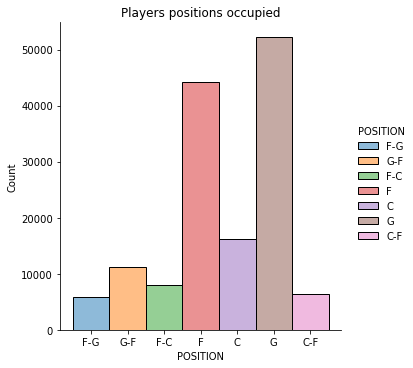

In [13]:
sns.displot(data = df_subset, x = "POSITION", hue = "POSITION")
plt.title("Players positions occupied")
plt.show()

From the countplot created, we can see that players log in our dataset have occupied traditional positions with Guard and Forward being more frequent and then Center significantly less. The other categories represents positions filled by players that are able to perform in two positions generally. We know that positions in an NBA game is not very strict as some players are able to cover many positions such as LeBron James (Emerick, 2017). and Also it is dependant on rotaion and Offesinve/Defensive plan of the team (Riches, 2013).

Now let's have a look at the field goal made distribution with position. 

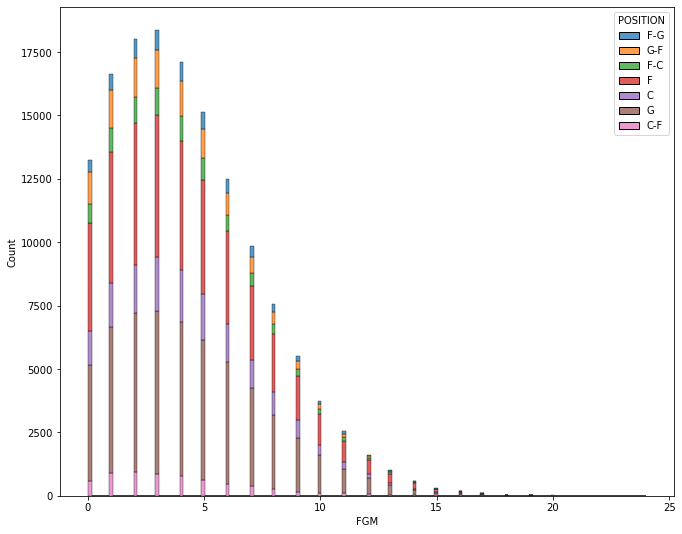

In [14]:
dims = (11, 9)
fig = plt.subplots(figsize=dims)
#sns.boxplot(data=df_subset, x="POSITION", y= "FG3M")
sns.histplot(data = df_subset, x = "FGM", hue = "POSITION", multiple = "stack")
plt.show()

It seems that players with occupation Forward have the highest number of field goals made with Guard/Forward. it make sense because these are the players that drives and gets closed to the basket. And players with occupation guard only have the least because they carry the assist and run the play to facilitate scoring. Unless, taking long shots from the outer perimiter (3 point shot), then the distribution might be different.

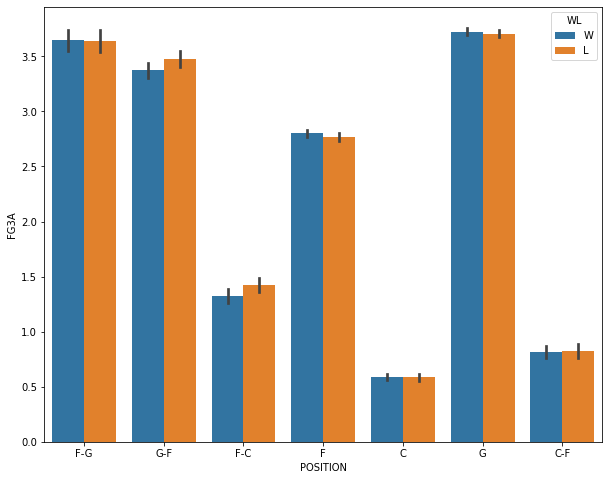

In [15]:
dims = (10, 8)
fig = plt.subplots(figsize=dims)
sns.barplot(data=df_subset, x="POSITION", y= "FG3A", hue= "WL")
plt.show()

The plot confirms what we mentioned earlier. Players that occupies positions on the upper side of the court, such as guard takes more 3-points shot in comparison to players on the inside. Also, in games where outcome is a win, they seem to take 3-point shots slightly higher. What seem to be interesting appears also is that players with occupation of Center and Forward/Center tends to take 3-points shot attempt in games that have an outcome of Loss. This might be something for further exploration also. 

Now let's look at the distribution of Field Goals Attempt (FGA) and Field Goal Made (FGM) in our population.

The median of field goal attempt (FGA) by players is: 9.0 shot
The mean field goal attempt (FGA) by players is: 9.348039147636566 shot


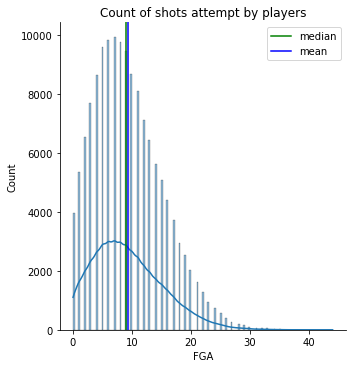

The median field goal made (FGM) by players is: 4.0 shot
The mean field goal made (FGM) by players is: 4.324522801415978 shot


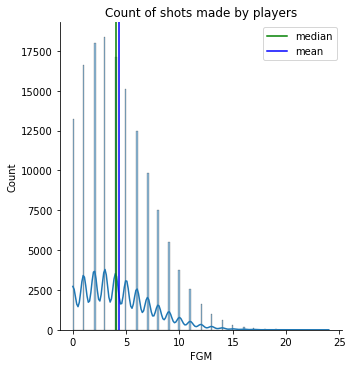

In [17]:
#df_subset = df_subset[df_subset["POSITION"] != "C"]
mean_size = df_subset['FGA'].mean()
median_size = df_subset['FGA'].median()
print(f'The median of field goal attempt (FGA) by players is: {median_size} shot')
print(f'The mean field goal attempt (FGA) by players is: {mean_size} shot')
sns.displot(data = df_subset, x = "FGA",kde = True)
plt.axvline(median_size, 0, 100, color='green', label='median')
plt.axvline(mean_size, 0, 100, color='blue', label='mean') 
plt.title("Count of shots attempt by players")
plt.legend()
plt.show()

mean_size = df_subset['FGM'].mean()
median_size = df_subset['FGM'].median()
print(f'The median field goal made (FGM) by players is: {median_size} shot')
print(f'The mean field goal made (FGM) by players is: {mean_size} shot')
sns.displot(data = df_subset, x = "FGM", kde = True)
plt.axvline(median_size, 0, 100, color='green', label='median')
plt.axvline(mean_size, 0, 100, color='blue', label='mean') 
plt.title("Count of shots made by players")
plt.legend()
plt.show()

What we can conclude from those two plots is that players in our set, have an average of 9.32 shot attempt and an average of approximetly 4.32 shot made. while the Median in the shot attempts is 9 and for shots made is 4. 
We can also conclude that the data is right skewed in both cases. 

Finally, let's look at the Field Goal Attemps/made and 3-point shots attempt/made taken by players from an age perspective. Generally, younger players tend to be more athletic and drive to the basket more than older players. As some older players even work on improving their long distance shot to stay efficient and prolong their carrier (Harvardsports, 2017).

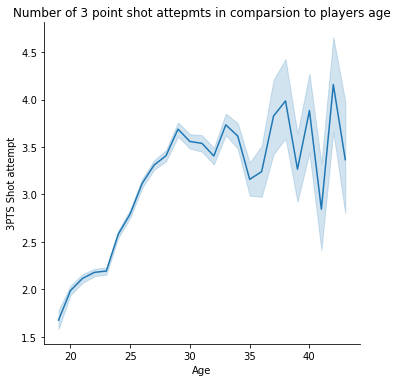

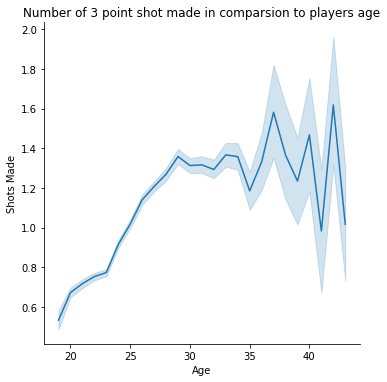

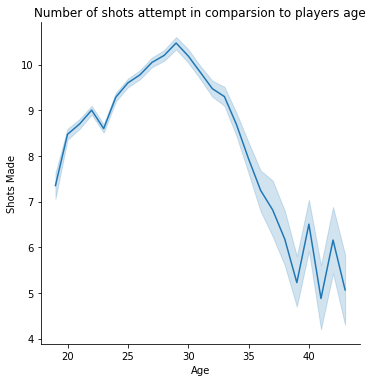

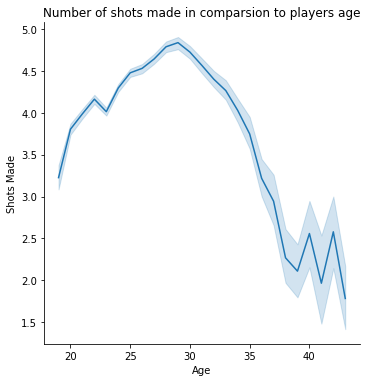

In [19]:
sns.relplot(data = df_subset, x = "AGE", y = "FG3A", kind = "line")
plt.xlabel("Age")
plt.ylabel("3PTS Shot attempt")
plt.title("Number of 3 point shot attepmts in comparsion to players age")
plt.show()

sns.relplot(data = df_subset, x = "AGE", y = "FG3M", kind = "line")
plt.xlabel("Age")
plt.ylabel("Shots Made")
plt.title("Number of 3 point shot made in comparsion to players age")
plt.show()

sns.relplot(data = df_subset, x = "AGE", y = "FGA", kind = "line")
plt.xlabel("Age")
plt.ylabel("Shots Made")
plt.title("Number of shots attempt in comparsion to players age")
plt.show()

sns.relplot(data = df_subset, x = "AGE", y = "FGM", kind = "line")
plt.xlabel("Age")
plt.ylabel("Shots Made")
plt.title("Number of shots made in comparsion to players age")
plt.show()

By looking at the relationship plots above, we can clearly see that the shots attempt and made increase with age. The drop we see Field Goal Attempt and made can be explained by the fact that players are near the end of their career after the age of 35. But it notiable that 3 points shot attempts and scoring increases with age.

#### Analyzing correlations and splitting the dataset

We start our model by looking at features correlations and see in case we need perform some transformations on any of our variables. In order to make our plot smaller, we will only look at the dependant variable (FG3M in our case). 

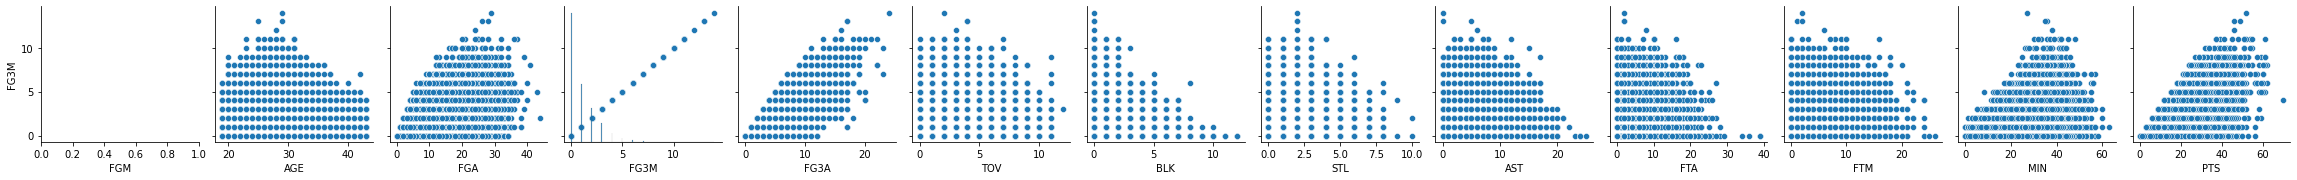

In [20]:
sns.pairplot(df_subset, y_vars = "FG3M")
plt.show()

After looking at the plot, we realize that our independat variables chosen have some sort of a weak to moderate correlation. With some of the variables showing some data points to be a bit off. lets look at the correlation matrix below and try to visualize it in a heat map to get a better view on the correlation. No transformation is required.

In [21]:
corr = df_subset[["FGM","FGA","FG3M","FG3A","TOV", "BLK","STL" ,"AST", "FTA", "FTM","AGE","MIN"]].corr()
corr

,FGM,FGA,FG3M,FG3A,TOV,BLK,STL,AST,FTA,FTM,AGE,MIN
FGM,1.000000,0.873319,0.471522,0.422320,0.372615,0.154115,0.262287,0.378291,0.460159,0.454021,0.049949,0.683319
FGA,0.873319,1.000000,0.449295,0.571032,0.416947,0.113349,0.292781,0.455097,0.489279,0.497256,0.054906,0.760285
FG3M,0.471522,0.449295,1.000000,0.815057,0.155389,-0.074724,0.127486,0.227549,0.110259,0.149198,0.163435,0.351787
FG3A,0.422320,0.571032,0.815057,1.000000,0.201788,-0.098694,0.166765,0.303992,0.152992,0.201714,0.192326,0.433027
TOV,0.372615,0.416947,0.155389,0.201788,1.000000,0.080977,0.216803,0.395014,0.337837,0.331313,-0.003424,0.436069
BLK,0.154115,0.113349,-0.074724,-0.098694,0.080977,1.000000,0.042345,-0.022688,0.160142,0.120163,-0.023141,0.201726
STL,0.262287,0.292781,0.127486,0.166765,0.216803,0.042345,1.000000,0.281360,0.199185,0.195016,0.022112,0.354609
AST,0.378291,0.455097,0.227549,0.303992,0.395014,-0.022688,0.281360,1.000000,0.296271,0.311238,0.093613,0.481548
FTA,0.460159,0.489279,0.110259,0.152992,0.337837,0.160142,0.199185,0.296271,1.000000,0.949676,-0.012314,0.477583
FTM,0.454021,0.497256,0.149198,0.201714,0.331313,0.120163,0.195016,0.311238,0.949676,1.000000,0.005414,0.466660


Now let's look at _Pearson R_ with the _P_ Values

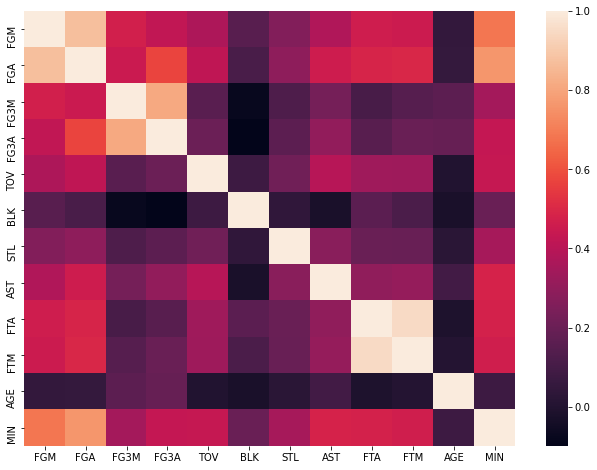

In [22]:
dims = (11, 8)
fig = plt.subplots(figsize=dims)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

In [23]:
print(pearsonr(df_subset["FGM"],df_subset["FGA"]))
print(pearsonr(df_subset["FGM"],df_subset["FG3M"]))
print(pearsonr(df_subset["FGM"],df_subset["FG3A"]))
print(pearsonr(df_subset["FGM"],df_subset["TOV"]))
print(pearsonr(df_subset["FGM"],df_subset["BLK"]))
print(pearsonr(df_subset["FGM"],df_subset["STL"]))
print(pearsonr(df_subset["FGM"],df_subset["AST"]))
print(pearsonr(df_subset["FGM"],df_subset["FTA"]))
print(pearsonr(df_subset["FGM"],df_subset["FTM"]))
print(pearsonr(df_subset["FGM"],df_subset["AGE"]))
print(pearsonr(df_subset["FGM"],df_subset["MIN"]))

(0.8733185439022433, 0.0)
(0.47152244931668463, 0.0)
(0.422319695812059, 0.0)
(0.37261541423745304, 0.0)
(0.1541150254191703, 0.0)
(0.26228728140008395, 0.0)
(0.3782905710720285, 0.0)
(0.46015872712438016, 0.0)
(0.4540207993143438, 0.0)
(0.0499492443288611, 2.9797708434252064e-80)
(0.6833187139058896, 0.0)


Aftet visualizing the correlation, and looking at the P values. we will do the following:
* FGM seem to have a strong positive correlation with FGA with  _R_ = 0.87 and a _P_ <0.001
* FGM seem to have a moderate positive correlation with FG3M with  _R_ = 0.47 and a _P_ <0.001
* FGM seem to have a moderate positive correlation with FG3A with  _R_ = 0.42 and a _P_ <0.001
* FGM seem to have a weak positive correlation with FGA with  _R_ = 0.37 and a _P_ <0.001
* FGM seem to have a weak positive correlation with BLK with  _R_ = 0.15 and a _P_ <0.001
* FGM seem to have a weak positive correlation with STL with  _R_ = 0.26 and a _P_ <0.001
* FGM seem to have a weak positive correlation with AST with  _R_ = 0.37 and a _P_ <0.001
* FGM seem to have a moderate positive correlation with FTA with  _R_ = 0.46 and a _P_ <0.001
* FGM seem to have a weak positive correlation with FTM with  _R_ = 0.45 and a _P_ <0.001
* FGM seem to have a weak correlation with AGE with  _R_ = 0.04 and a _P_ > 0.001 and almost = 3
* FGM seem to have a weak positive correlation with MIN with  _R_ = 0.68 and a _P_ <0.001

Therefore, we will take these variables into our model and decide to drop the age. Also, we will take the **PLAYING_FOR**, **PLAYING_AGAINST** and **POSITION** categorical variables. As these variables, in our assumption, have some impact since a every player has a specific position that either allows him to shoot more and score more. And every team team have their own deffensive and offensive strategies that might affect the outcome.



In [24]:
# creating dummy variables
df_modified = pd.get_dummies(df_subset, columns={"POSITION", "PLAYING_FOR", "PLAYING_AGAINST"})
# dropping columns we wont be using
df_modified = df_modified.drop(columns= {"WL", "PTS", "SEASON_ID", "AGE"})
# visualizing the dataset
df_modified

,FGM,PLAYER_FULL_NAME,FGA,FG3M,FG3A,TOV,BLK,STL,AST,FTA,...,PLAYING_FOR_TOR,PLAYING_FOR_UTA,PLAYING_FOR_WAS,POSITION_C,POSITION_C-F,POSITION_F,POSITION_F-C,POSITION_F-G,POSITION_G,POSITION_G-F
26472,13,Vince Carter,22,0,1,1,2,2,6,5,...,1,0,0,0,0,0,0,1,0,0
26304,11,Vince Carter,20,3,6,3,3,1,11,5,...,1,0,0,0,0,0,0,0,0,1
26195,9,Vince Carter,17,1,3,4,0,0,1,2,...,1,0,0,0,0,0,0,0,0,1
111182,2,Nene,11,0,0,6,1,1,1,6,...,0,0,0,0,0,0,1,0,0,0
87185,3,Kyle Korver,7,3,6,4,0,1,0,4,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68018,7,Jrue Holiday,17,5,9,2,0,2,7,0,...,0,0,0,0,0,0,0,0,1,0
72220,3,Kevin Huerter,9,1,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
107397,4,Monte Morris,10,1,1,0,0,0,8,0,...,0,0,0,0,0,0,0,0,1,0
46455,0,Bruno Fernando,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,1,0,0,0


Now, we are going to split our set into a training set and a test set by taking a ratio of 70% training and 30% test. We will use a __random_state__ of 1 to avoid getting random values everytime we run this cell.

In [25]:
y = df_modified["FGM"]
X = df_modified.loc[:,"FGA":"PLAYING_AGAINST_YK"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

## Building The Predictive Model

For our model, we are going to use Random Forest Regressor. We are going to use __n_estimators__ = 100, which means the number of trees generated is 100. We will not perform any other tuning on the parameters of the Random Forest. Description of how Random Forest algorithm works will be provided in Part 2 of this notebook.

In [26]:
regressor = RandomForestRegressor(n_estimators=100)

In [27]:
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [28]:
y_test_p = regressor.predict(X_test)

## Evaluating The Model

In [29]:
regressor.score(X_test, y_test)

0.8211007507787279

Our model has an $ R^2 $ score of 0.82. which is good. $ R^2 $ basically tells me how well my model fits the data. 
It is basically calculated in the following way: $ R^2 = 1 - \frac{RSS}{TSS} $ where _RSS_ is the sum of the squared residuals and _TSS_ is the total sum of squares.

Now, let's look on the _Root Mean Squared Error_ in our model. _Root Mean Squared Error_ basically it measures the difference of values predicted by our model and the observed values. In other words, it measures how off is our predictions. The general formula is as follows: $ \sqrt{\frac{\sum{(\hat{y} - y)^2}}{N}} $ where $ \hat{y} $ is the predicted value, $ y $ is the actual observed value and $ N $ is the number of data points.

In [30]:
math.sqrt(mean_squared_error(y_test, y_test_p))

1.339725126485414

Based on the output of the _RMSE_, our model has a typical error of 1.33 shot. 

### Building the model with a new intuition

Our previous model has returned good results. But, we hypothasize that in case we added a new categorical variable things might change. NBA players have characteristics with some players considered key and star players that performs differently than others. In the following section, we are going to rebuild the model but by adding the name of the player. Our hypothesis is that the model might be reflect real life situations and therefor have a real life application.

In [86]:
# creating dummy variables
df_modified = pd.get_dummies(df_subset, columns={"POSITION", "PLAYING_FOR", "PLAYING_AGAINST", "PLAYER_FULL_NAME"})
# dropping columns we wont be using
df_modified = df_modified.drop(columns= {"WL", "PTS", "AGE", "SEASON_ID"})
# visualizing the dataset
df_modified

,FGM,FGA,FG3M,FG3A,TOV,BLK,STL,AST,FTA,FTM,...,PLAYER_FULL_NAME_Zhaire Smith,PLAYER_FULL_NAME_Zion Williamson,PLAYER_FULL_NAME_Zylan Cheatham,POSITION_C,POSITION_C-F,POSITION_F,POSITION_F-C,POSITION_F-G,POSITION_G,POSITION_G-F
26472,13,22,0,1,1,2,2,6,5,5,...,0,0,0,0,0,0,0,1,0,0
26304,11,20,3,6,3,3,1,11,5,3,...,0,0,0,0,0,0,0,0,0,1
26195,9,17,1,3,4,0,0,1,2,1,...,0,0,0,0,0,0,0,0,0,1
111182,2,11,0,0,6,1,1,1,6,6,...,0,0,0,0,0,0,1,0,0,0
87185,3,7,3,6,4,0,1,0,4,3,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68018,7,17,5,9,2,0,2,7,0,0,...,0,0,0,0,0,0,0,0,1,0
72220,3,9,1,5,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
107397,4,10,1,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,1,0
46455,0,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,1,0,0,0


In [87]:
# Creating the X and y variables.
y = df_modified.loc[:,"FGM"]
X = df_modified.loc[:,"FGA":"PLAYER_FULL_NAME_Zylan Cheatham"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [88]:
new_rf_regressor = RandomForestRegressor(n_estimators=100)

In [89]:
new_rf_regressor.fit(X_train, y_train)

RandomForestRegressor()

In [90]:
y_test_p = new_rf_regressor.predict(X_test)

In [91]:
new_rf_regressor.score(X_test, y_test)

0.8267353373414245

In [92]:
math.sqrt(mean_squared_error(y_test, y_test_p))

1.318458432842596

By adding __PLAYER_FULL_NAME__ into our model we saw a very slight improvement in the $ R^2 $ score becoming 0.8289 instead of 0.8281 and _RSME_ has also dropped from 1.31 Field Goal Made to 1.30 Field Goal Made.

That being said, we now have a proposition for a model that can predict how many Field Goals a player will score in the upcoming games based on historic data trained. And based on prediction outcome of the model, a team can improve the scoring ability of players in upcoming future games.

# Part 2: Win Loss Prediction

In this part, we will attempt to build a model that analyzes 10 years of historic games data (2010-2020) and try to predict the outcome of a game. In this model, we hypothasize that in order to predict an outcome of a game we need to feed our model data that is based on half time stats of a game, and add the outcome of that game to it (W/L). A Basketball game has 4 quarters, the first two quarters are considered Half-time. We want our model to take the patterns that are available in the half time of those games, with outcome of the full-time and then predict the results of a full time of a game.

We are trying to build a model that has a practicle application in helping teams predicting an outcome of a game based on the historic data. And then make the necessary changes during the half-time break.

## Getting  Datasets from the API

First, we start by fetching the data from the api. We create a list that contains seasons year, and pass it to the API.

**NOTE: RUNNING THE CODE INSIDE THIS SECTION TAKES UP TO 6 HOURS DUE TO API LIMITATION. PLEASE DO NOT RUN THIS SECTION UNLESS IT IS ABSOLUTELY NECESSARY. ALL THE DATASETS ARE AVAILABLE IN THE DROPBOX LINK ON TOP OF THE PAGE**

We start by creating a list that contains the seaons we want to get data for.

In [108]:
seasons_list = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
print(seasons_list)

['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']


First, we need to get the id of the games played on the seasons we have in our list. <a href="https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguegamelog.md">End point documenation can be here</a>. 

In [109]:
# creating a counter for sleep time
counter = 0
for season_item in seasons_list:
    temp_df = leaguegamelog.LeagueGameLog(season= season_item).get_data_frames()[0]
    df_league_game_log = pd.concat([df_league_game_log, temp_df], axis = 0)
    counter+=1
    if counter == 5:
        time.sleep(5)
        counter = 0
df_league_game_log.to_csv("League_game_log_master.csv")
# adjusting game id so it can fit the request in boxscoretraditional endpoint
df_league_game_log["GAME_ID"] = "00"+df_league_game_log["GAME_ID"].astype(str)

Then, due to API limitation, we create a list of the **SEASON_ID** and **GAME_ID**, and subset the data for every signle season. (ie. games in season 2010, games in season 2011 etc..)

In [163]:
# Creating a list of every game ID in every season

## SEASON 2010 ###
# creating a unique list of game id from dataframe
game_id_list_2010 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2010 = game_id_list_2010[game_id_list_2010["SEASON_ID"] == 22010]
game_id_list_2010 = game_id_list_2010["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2010 = game_id_list_2010.tolist()
#################
## SEASON 2011 ###
# creating a unique list of game id from dataframe
game_id_list_2011 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2011 = game_id_list_2011[game_id_list_2011["SEASON_ID"] == 22011]
game_id_list_2011 = game_id_list_2011["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2011 = game_id_list_2011.tolist()
#################
## SEASON 2012 ###
# creating a unique list of game id from dataframe
game_id_list_2012 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2012 = game_id_list_2012[game_id_list_2012["SEASON_ID"] == 22012]
game_id_list_2012 = game_id_list_2012["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2012 = game_id_list_2012.tolist()
#################
## SEASON 2013 ###
# creating a unique list of game id from dataframe
game_id_list_2013 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2013 = game_id_list_2013[game_id_list_2013["SEASON_ID"] == 22013]
game_id_list_2013 = game_id_list_2013["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2013 = game_id_list_2013.tolist()
#################
## SEASON 2014 ###
# creating a unique list of game id from dataframe
game_id_list_2014 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2014 = game_id_list_2014[game_id_list_2014["SEASON_ID"] == 22014]
game_id_list_2014 = game_id_list_2014["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2014 = game_id_list_2014.tolist()
#################
## SEASON 2014 ###
# creating a unique list of game id from dataframe
game_id_list_2015 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2015 = game_id_list_2015[game_id_list_2015["SEASON_ID"] == 22015]
game_id_list_2015 = game_id_list_2015["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2015 = game_id_list_2015.tolist()
#################
## SEASON 2016 ###
# creating a unique list of game id from dataframe
game_id_list_2016 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2016 = game_id_list_2016[game_id_list_2016["SEASON_ID"] == 22016]
game_id_list_2016 = game_id_list_2016["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2016 = game_id_list_2016.tolist()
#################
## SEASON 2017 ###
# creating a unique list of game id from dataframe
game_id_list_2017 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2017 = game_id_list_2017[game_id_list_2017["SEASON_ID"] == 22017]
game_id_list_2017 = game_id_list_2017["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2017 = game_id_list_2017.tolist()
#################
## SEASON 2018 ###
# creating a unique list of game id from dataframe
game_id_list_2018 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2018 = game_id_list_2018[game_id_list_2018["SEASON_ID"] == 22018]
game_id_list_2018 = game_id_list_2018["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2018 = game_id_list_2018.tolist()
#################
## SEASON 2019 ###
# creating a unique list of game id from dataframe
game_id_list_2019 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2019 = game_id_list_2019[game_id_list_2019["SEASON_ID"] == 22019]
game_id_list_2019 = game_id_list_2019["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2019 = game_id_list_2019.tolist()
#################
## SEASON 2020 ###
# creating a unique list of game id from dataframe
game_id_list_2020 = df_league_game_log[["SEASON_ID","GAME_ID"]].copy()
game_id_list_2020 = game_id_list_2020[game_id_list_2020["SEASON_ID"] == 22020]
game_id_list_2020 = game_id_list_2020["GAME_ID"].unique()
# changing the type from numpy array to list
game_id_list_2020 = game_id_list_2020.tolist()
#################


After finishing with the creating the lists, we pass the data to an endpoint called <a href="https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/boxscoretraditionalv2.md">boxscore</a>  in the API to get the data of games in every single season. We also add parameters based on <a href="https://github.com/swar/nba_api/issues/74">API documentation</a> to get the halftime stats. 


After fetching the data, we store it inside dataframes then we create a master dataframe and save the outcome in a CSV file for later use.

In [165]:
# Creating an empty master dataframe for later use
df_boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore = df_boxscore.get_data_frame()
df_boxscore = df_boxscore.iloc[0:0]

################
## SEASON 2010
###############
print("Getting data for season 2010")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2010 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2010 = df_boxscore_2010.get_data_frame()
df_boxscore_2010 = df_boxscore_2010.iloc[0:0]
try:
    for game in game_id_list_2010:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2010 = pd.concat([df_boxscore_2010, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0        
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2011
###############
print("Getting data for season 2011")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2011 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2011 = df_boxscore_2011.get_data_frame()
df_boxscore_2011 = df_boxscore_2011.iloc[0:0]
try:
    for game in game_id_list_2011:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2011 = pd.concat([df_boxscore_2011, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0        
    
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2012
###############
print("Getting data for season 2012")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2012 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2012 = df_boxscore_2012.get_data_frame()
df_boxscore_2012 = df_boxscore_2012.iloc[0:0]
try:
    for game in game_id_list_2012:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2012 = pd.concat([df_boxscore_2012, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0 
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2013
###############
print("Getting data for season 2013")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2013 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2013 = df_boxscore_2013.get_data_frame()
df_boxscore_2013 = df_boxscore_2013.iloc[0:0]
try:
    for game in game_id_list_2013:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2013 = pd.concat([df_boxscore_2013, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0        
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2014
###############
print("Getting data for season 2014")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2014 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2014 = df_boxscore_2014.get_data_frame()
df_boxscore_2014 = df_boxscore_2014.iloc[0:0]
try:
    for game in game_id_list_2014:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2014 = pd.concat([df_boxscore_2014, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0   
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2015
###############
print("Getting data for season 2015")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2015 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2015 = df_boxscore_2015.get_data_frame()
df_boxscore_2015 = df_boxscore_2015.iloc[0:0]
try:
    for game in game_id_list_2015:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2015 = pd.concat([df_boxscore_2015, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0        
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2016
###############
print("Getting data for season 2016")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2016 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2016 = df_boxscore_2016.get_data_frame()
df_boxscore_2016 = df_boxscore_2016.iloc[0:0]
try:
    for game in game_id_list_2016:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2016 = pd.concat([df_boxscore_2016, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2017
###############
print("Getting data for season 2017")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2017 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2017 = df_boxscore_2017.get_data_frame()
df_boxscore_2017 = df_boxscore_2017.iloc[0:0]
try:
    for game in game_id_list_2017:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2017 = pd.concat([df_boxscore_2017, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0   
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2018
###############
print("Getting data for season 2018")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2018 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2018 = df_boxscore_2018.get_data_frame()
df_boxscore_2018 = df_boxscore_2018.iloc[0:0]
try:
    for game in game_id_list_2018:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2018 = pd.concat([df_boxscore_2018, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0    
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2019
###############
print("Getting data for season 2019")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2019 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2019 = df_boxscore_2019.get_data_frame()
df_boxscore_2019 = df_boxscore_2019.iloc[0:0]
try:
    for game in game_id_list_2019:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2019 = pd.concat([df_boxscore_2019, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0      
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)
################
## SEASON 2020
###############
print("Getting data for season 2020")
# creating a counter for sleep time in the loop, to avoid API crashing
counter_1 = 0
# Getting the data from the API and then dropping the values in it to get an empty and structured Dataframe
# to empty the values
df_boxscore_2020 = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id_list[0], range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400).team_stats
df_boxscore_2020 = df_boxscore_2020.get_data_frame()
df_boxscore_2020 = df_boxscore_2020.iloc[0:0]
try:
    for game in game_id_list_2020:
        df_temp = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game, range_type=2,start_period=1, end_period = 2, start_range=0, end_range = 14400, timeout=10).team_stats
        df_temp = df_temp.get_data_frame()
        df_boxscore_2020 = pd.concat([df_boxscore_2020, df_temp], axis = 0)
        counter_1+=1
        if counter_1 == 100:
            time.sleep(10)
            counter_1 = 0     
except requests.exceptions.Timeout:
    print("A timeout error has occured")
time.sleep(10)

# fixing Season ID on every data frame
df_boxscore_2013["SEASON_ID"] = "2010"
df_boxscore_2013["SEASON_ID"] = "2011"
df_boxscore_2013["SEASON_ID"] = "2012"
df_boxscore_2013["SEASON_ID"] = "2013"
df_boxscore_2014["SEASON_ID"] = "2014"
df_boxscore_2015["SEASON_ID"] = "2015"
df_boxscore_2016["SEASON_ID"] = "2016"
df_boxscore_2017["SEASON_ID"] = "2017"
df_boxscore_2018["SEASON_ID"] = "2018"
df_boxscore_2019["SEASON_ID"] = "2019"
df_boxscore_2020["SEASON_ID"] = "2020"

# concatinating all dataframes into a single master and creating a csv copy
df_boxscore = pd.concat([df_boxscore, df_boxscore_2010], axis=0)
df_boxscore = pd.concat([df_boxscore, df_boxscore_2011], axis=0)
df_boxscore = pd.concat([df_boxscore, df_boxscore_2012], axis=0)
df_boxscore = pd.concat([df_boxscore, df_boxscore_2013], axis=0)
df_boxscore = pd.concat([df_boxscore, df_boxscore_2014], axis=0)
df_boxscore = pd.concat([df_boxscore, df_boxscore_2016], axis=0)
df_boxscore = pd.concat([df_boxscore, df_boxscore_2017], axis=0)
df_boxscore = pd.concat([df_boxscore, df_boxscore_2018], axis=0)
df_boxscore = pd.concat([df_boxscore, df_boxscore_2019], axis=0)
df_boxscore = pd.concat([df_boxscore, df_boxscore_2020], axis=0)
df_boxscore.to_csv("boxscore_master.csv")

Getting data for season 2010
Getting data for season 2011
Getting data for season 2012
Getting data for season 2013
Getting data for season 2014
Getting data for season 2015
Getting data for season 2016
Getting data for season 2017
Getting data for season 2018
Getting data for season 2019
Getting data for season 2020


## Feature Engineering:

In the section, we are going to perform some changes and get data from different dataframes we fetched earlier from the endpoitns. While looking at dataframe boxscore, we noticed that __GAME_ID__ is missing "00" at the beginning of some games in both dataframes so we add it and drop the column __Unnamed: 0__

In [111]:
# getting the data from the CSV file creater earlier
df_boxscore = pd.read_csv("boxscore_master.csv")

# dropping column "Unnamed: 0"

df_boxscore.drop(columns = {"Unnamed: 0"}, inplace = True)

# adding a 00 at the begining of GAME_ID to match the df_boxscore with df_league_game_log
df_boxscore["GAME_ID"] = "00"+df_boxscore["GAME_ID"].astype(str)
df_boxscore.head()

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,FGM,FGA,FG_PCT,FG3M,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEASON_ID
0,0021000003,1610612747,Lakers,LAL,Los Angeles,120:00,21,54,0.389,2,...,15,24,12,4,3,5,11,51,-11.0,2010
1,0021000003,1610612745,Rockets,HOU,Houston,120:00,23,48,0.479,6,...,22,29,14,3,4,9,12,62,11.0,2010
2,0021000001,1610612748,Heat,MIA,Miami,120:00,11,41,0.268,1,...,15,22,5,7,4,9,7,30,-15.0,2010
3,0021000001,1610612738,Celtics,BOS,Boston,120:00,17,38,0.447,3,...,21,25,12,2,4,11,9,45,15.0,2010
4,0021000002,1610612757,Trail Blazers,POR,Portland,120:00,19,43,0.442,4,...,16,25,13,4,1,9,10,50,4.0,2010


The data set contains all the stats of a team on a specific game in the half time.

Now, let's load the dataframe **League_game_log_master** from the CSV saved earlier. We apply some lambda function on the team abbriviation to get the name of team two. While doing so we noticed that some matchup data has a character "@" instead of "vs." so we implement an if statement to get the proper results.

In [112]:
df_league_game_log = pd.read_csv("League_game_log_master.csv")
# Removing the extra column unamed
df_league_game_log = df_league_game_log.drop(columns={"Unnamed: 0"})
# adjusting game id so it can fit the request in boxscoretraditional endpoint
df_league_game_log["GAME_ID"] = "00"+df_league_game_log["GAME_ID"].astype(str)

# getting the abbriviation of team 2 in the matchup to add it to boxscore dataframe
df_league_game_log["TEAM_2_ABBRIVIATION"] = df_league_game_log["MATCHUP"].apply(lambda x: x[7:11] if "vs" in x  else x[6:9])

df_league_game_log.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,TEAM_2_ABBRIVIATION
0,22010,1610612747,LAL,Los Angeles Lakers,0021000003,2010-10-26,LAL vs. HOU,W,240,40,...,44,21,11,4,12,24,112,2,0,HOU
1,22010,1610612745,HOU,Houston Rockets,0021000003,2010-10-26,HOU @ LAL,L,240,38,...,53,25,6,7,21,25,110,-2,0,LAL
2,22010,1610612738,BOS,Boston Celtics,0021000001,2010-10-26,BOS vs. MIA,W,240,32,...,42,25,6,4,20,19,88,8,0,MIA
3,22010,1610612748,MIA,Miami Heat,0021000001,2010-10-26,MIA @ BOS,L,240,27,...,39,15,10,6,17,21,80,-8,0,BOS
4,22010,1610612756,PHX,Phoenix Suns,0021000002,2010-10-26,PHX @ POR,L,240,36,...,30,15,3,4,19,19,92,-14,0,POR


Now, in order to get the outcome of a game **WL** and the name of the oposing team, we create a temporary key consisting of **TEAM_ID** and **GAME_ID**. This way whe can join both data frames and get the outcome based on a specific key available in both dataframes. Since a game consist of two teams playing against eachothe of course, we want our algorithm later on determin an outcome with opposing team being taken into consideration. 

In [113]:
# creating a temp key to join with df_league_game_log
df_boxscore["TEMP_ID"] = df_boxscore["TEAM_ID"].astype(str)+"-"+df_boxscore["GAME_ID"].astype(str)

# creating a temp key to join with df_boxscore
df_league_game_log["TEMP_ID"] = df_league_game_log["TEAM_ID"].astype(str)+"-"+df_league_game_log["GAME_ID"].astype(str)

# joining df_boxscore with WL and team abbriviation, similar to SQL left outer join statement
df_boxscore = pd.merge(df_boxscore, df_league_game_log[["TEMP_ID", "TEAM_2_ABBRIVIATION","WL"]], how = "left", on = "TEMP_ID")
df_boxscore = df_boxscore.rename(columns={"TEAM_2_ABBRIVIATION" : "PLAYING_AGAINST"})
df_boxscore = df_boxscore.drop(columns = {"TEMP_ID"})

df_boxscore.head()

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,FGM,FGA,FG_PCT,FG3M,...,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEASON_ID,PLAYING_AGAINST,WL
0,0021000003,1610612747,Lakers,LAL,Los Angeles,120:00,21,54,0.389,2,...,12,4,3,5,11,51,-11.0,2010,HOU,W
1,0021000003,1610612745,Rockets,HOU,Houston,120:00,23,48,0.479,6,...,14,3,4,9,12,62,11.0,2010,LAL,L
2,0021000001,1610612748,Heat,MIA,Miami,120:00,11,41,0.268,1,...,5,7,4,9,7,30,-15.0,2010,BOS,L
3,0021000001,1610612738,Celtics,BOS,Boston,120:00,17,38,0.447,3,...,12,2,4,11,9,45,15.0,2010,MIA,W
4,0021000002,1610612757,Trail Blazers,POR,Portland,120:00,19,43,0.442,4,...,13,4,1,9,10,50,4.0,2010,PHX,W


Now let's have a look at the boxscore dataframe and decide which columns we want to take for our subset. And see if we have any missing entries.

In [114]:
df_boxscore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33948 entries, 0 to 33947
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GAME_ID            33948 non-null  object 
 1   TEAM_ID            33948 non-null  int64  
 2   TEAM_NAME          33948 non-null  object 
 3   TEAM_ABBREVIATION  33948 non-null  object 
 4   TEAM_CITY          33948 non-null  object 
 5   MIN                33948 non-null  object 
 6   FGM                33948 non-null  int64  
 7   FGA                33948 non-null  int64  
 8   FG_PCT             33948 non-null  float64
 9   FG3M               33948 non-null  int64  
 10  FG3A               33948 non-null  int64  
 11  FG3_PCT            33948 non-null  float64
 12  FTM                33948 non-null  int64  
 13  FTA                33948 non-null  int64  
 14  FT_PCT             33948 non-null  float64
 15  OREB               33948 non-null  int64  
 16  DREB               339

In [115]:
# choosing the columns
df_boxscore_subset = df_boxscore[["WL", "SEASON_ID","GAME_ID","TEAM_ABBREVIATION", "FGA", "FGM",  "FG3A", "FG3M", "FTA",
                                 "FTM", "OREB", "DREB", "REB", "AST", "STL", "BLK", "TO", "PTS", "PLAYING_AGAINST"]]

df_boxscore_subset

,WL,SEASON_ID,GAME_ID,TEAM_ABBREVIATION,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,REB,AST,STL,BLK,TO,PTS,PLAYING_AGAINST
0,W,2010,0021000003,LAL,54,21,11,2,9,7,9,15,24,12,4,3,5,51,HOU
1,L,2010,0021000003,HOU,48,23,11,6,10,10,7,22,29,14,3,4,9,62,LAL
2,L,2010,0021000001,MIA,41,11,7,1,11,7,7,15,22,5,7,4,9,30,BOS
3,W,2010,0021000001,BOS,38,17,9,3,8,8,4,21,25,12,2,4,11,45,MIA
4,W,2010,0021000002,POR,43,19,8,4,11,8,9,16,25,13,4,1,9,50,PHX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33943,W,2020,0022000169,MEM,54,23,12,3,10,7,6,13,19,15,9,2,2,56,MIN
33944,L,2020,0022000172,NOP,48,17,15,4,5,5,10,16,26,7,1,3,5,43,LAC
33945,W,2020,0022000172,LAC,37,18,20,11,14,14,1,19,20,15,3,5,4,61,NOP
33946,L,2020,0022000173,SAC,42,24,19,11,12,9,2,21,23,21,1,1,6,68,POR


Now in our dataset, we have 2 game IDs, where each one belongs to one side of the game. To ensure we dont have duplicates, we are going to drop all the game ids that have a count more than 2 in our dataset. Then let's look at the results.

In [116]:
df_boxscore_subset["GAME_ID_Count"] = df_boxscore_subset.groupby("GAME_ID").cumcount()+1
df_boxscore_subset = df_boxscore_subset[df_boxscore_subset["GAME_ID_Count"]<3]
df_boxscore_subset = df_boxscore_subset.drop(columns={"GAME_ID_Count"})
df_boxscore_subset

<ipython-input-116-27935ba49e63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxscore_subset["GAME_ID_Count"] = df_boxscore_subset.groupby("GAME_ID").cumcount()+1


,WL,SEASON_ID,GAME_ID,TEAM_ABBREVIATION,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,REB,AST,STL,BLK,TO,PTS,PLAYING_AGAINST
0,W,2010,0021000003,LAL,54,21,11,2,9,7,9,15,24,12,4,3,5,51,HOU
1,L,2010,0021000003,HOU,48,23,11,6,10,10,7,22,29,14,3,4,9,62,LAL
2,L,2010,0021000001,MIA,41,11,7,1,11,7,7,15,22,5,7,4,9,30,BOS
3,W,2010,0021000001,BOS,38,17,9,3,8,8,4,21,25,12,2,4,11,45,MIA
4,W,2010,0021000002,POR,43,19,8,4,11,8,9,16,25,13,4,1,9,50,PHX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33943,W,2020,0022000169,MEM,54,23,12,3,10,7,6,13,19,15,9,2,2,56,MIN
33944,L,2020,0022000172,NOP,48,17,15,4,5,5,10,16,26,7,1,3,5,43,LAC
33945,W,2020,0022000172,LAC,37,18,20,11,14,14,1,19,20,15,3,5,4,61,NOP
33946,L,2020,0022000173,SAC,42,24,19,11,12,9,2,21,23,21,1,1,6,68,POR


Since the number of columns has dropped signigicantly, it seems that we had duplicated values in our dataset.

Before we proceed, we are going to explain what every column chosen for our subset means. It is worth mentioning that this process has been done from perspective of Team 1 and Team 2.

* __WL__: The outcome of a game, Win or Loss.
* __TEAM__: Name of the team in our dataset.
* __FGA__: Field Goal attempts by a team, the total number of shots on the basket done by a team regardless of the outcome.
* __FGM__: Field goal made by a team, the number total of successful shots done to the basket by a team.
* __FG3A__: Field goal 3 points attempt, the total number of 3 points shot attempt on the basket regardless of the outcome,
* __FG3M__: Field goal 3 points made, the total number of 3 points successful shot.
* __FTA__: Freethrow attempt, the total number of freethrows attempted by a team.
* __FTM__: Freethrow made, the total number of freethrows made by a team with successful outcome.
* __OREB__: Offensive rebound, the total number of rebound made by a team when attacking. A rebound is the recovery of the ball by a team member after a unsuccessful shot attempt. In this case, it is counted by the attacking team.
* __DREB__: Deffensive rebound, the total number of rebound made by a team. In this case, the recovery of the ball by the defending team after an unsuccessful shot attempt by the attcking team.
* __REB__: Reboudsm the total number of rebound my by a team regardless wether it was offensive or defensive.
* __AST__: Assist, the total number of assist made by a team. An assist is a pass done by a player that led to a quick score.
* __STL__: Steal, the total number of steals done by a team. A steal, as the name suggests, is counted when a player intercepts the ball and take it from the attacking team. 
* __BLK__: Blockshots, the total number of blockshots done by a team. A blockshot is when the defense knocks the ball away from the attacking players when they are performing a shot attempt to the basket.
* __TO__: Turnover, the total number of turnover done by a team. A turnover mainly is when the team looses possesion of the ball and results in the team loosing the ball to the opposing side.
* __PTS__: Points, the total number of points scored by the team.



Yet, we hypothasize that in order for our model to peform better we still need the stats of the opposing team to be added to our dataset. Therefor, we will end up with stats of the team we are trying to predict the outcome for at halftime, and the stats of the team they are going up against. In order to do so, and since we know that our subset has all the games available, we create a copy of the subset, change the names of the columns, create a temporary key consisting of the **GAME_ID** and the **PLAYING_AGAINST**. And finally, combine the two datasets together.

In [117]:
# strip the key columns from extra spaces
df_boxscore_subset["GAME_ID"] = df_boxscore_subset["GAME_ID"].str.strip()
df_boxscore_subset["TEAM_ABBREVIATION"] = df_boxscore_subset["TEAM_ABBREVIATION"].str.strip()
df_boxscore_subset["PLAYING_AGAINST"] = df_boxscore_subset["PLAYING_AGAINST"].str.strip()

# creating a copy of the original subset data
df_boxscore_opposing_team = df_boxscore_subset.loc[:,"SEASON_ID":"PTS"]

# creating a temporary key for the two datasets
df_boxscore_subset["TEMP_KEY"] = df_boxscore_subset["GAME_ID"]+df_boxscore_subset["PLAYING_AGAINST"]
df_boxscore_subset["TEMP_KEY"] = df_boxscore_subset["TEMP_KEY"].str.strip()
df_boxscore_opposing_team["TEMP_KEY"] = df_boxscore_opposing_team["GAME_ID"]+df_boxscore_opposing_team["TEAM_ABBREVIATION"]
df_boxscore_opposing_team["TEMP_KEY"] = df_boxscore_opposing_team["TEMP_KEY"].str.strip()

# creating a list of columns to programatically change the names of it.
opp_list = df_boxscore_opposing_team.columns.to_list()

#changing the names of columns in the opposing team dataframe programatically
for items in opp_list:
    if items == "TEMP_KEY":
        continue
    else:
        new_col = "OPP_TEAM_"+items
        df_boxscore_opposing_team = df_boxscore_opposing_team.rename(columns = {items : new_col})
# print resulting dataframe
df_boxscore_opposing_team

,OPP_TEAM_SEASON_ID,OPP_TEAM_GAME_ID,OPP_TEAM_TEAM_ABBREVIATION,OPP_TEAM_FGA,OPP_TEAM_FGM,OPP_TEAM_FG3A,OPP_TEAM_FG3M,OPP_TEAM_FTA,OPP_TEAM_FTM,OPP_TEAM_OREB,OPP_TEAM_DREB,OPP_TEAM_REB,OPP_TEAM_AST,OPP_TEAM_STL,OPP_TEAM_BLK,OPP_TEAM_TO,OPP_TEAM_PTS,TEMP_KEY
0,2010,0021000003,LAL,54,21,11,2,9,7,9,15,24,12,4,3,5,51,0021000003LAL
1,2010,0021000003,HOU,48,23,11,6,10,10,7,22,29,14,3,4,9,62,0021000003HOU
2,2010,0021000001,MIA,41,11,7,1,11,7,7,15,22,5,7,4,9,30,0021000001MIA
3,2010,0021000001,BOS,38,17,9,3,8,8,4,21,25,12,2,4,11,45,0021000001BOS
4,2010,0021000002,POR,43,19,8,4,11,8,9,16,25,13,4,1,9,50,0021000002POR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33943,2020,0022000169,MEM,54,23,12,3,10,7,6,13,19,15,9,2,2,56,0022000169MEM
33944,2020,0022000172,NOP,48,17,15,4,5,5,10,16,26,7,1,3,5,43,0022000172NOP
33945,2020,0022000172,LAC,37,18,20,11,14,14,1,19,20,15,3,5,4,61,0022000172LAC
33946,2020,0022000173,SAC,42,24,19,11,12,9,2,21,23,21,1,1,6,68,0022000173SAC


Now that we have our opposing team dataset ready, let's combine it with our boxscore_subset data and look at the results.

In [118]:
# merging the two dataframes
df_boxscore_subset = pd.merge(df_boxscore_subset, df_boxscore_opposing_team, how= "left", on = "TEMP_KEY")
# dropping the TEMP_KEY column and others unecessary columns
df_boxscore_subset.drop(columns = {"TEMP_KEY", "SEASON_ID", "GAME_ID","OPP_TEAM_SEASON_ID", "OPP_TEAM_GAME_ID","OPP_TEAM_TEAM_ABBREVIATION"}, inplace=True)
# printing the resulting dataframe
df_boxscore_subset

,WL,TEAM_ABBREVIATION,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,...,OPP_TEAM_FTA,OPP_TEAM_FTM,OPP_TEAM_OREB,OPP_TEAM_DREB,OPP_TEAM_REB,OPP_TEAM_AST,OPP_TEAM_STL,OPP_TEAM_BLK,OPP_TEAM_TO,OPP_TEAM_PTS
0,W,LAL,54,21,11,2,9,7,9,15,...,10,10,7,22,29,14,3,4,9,62
1,L,HOU,48,23,11,6,10,10,7,22,...,9,7,9,15,24,12,4,3,5,51
2,L,MIA,41,11,7,1,11,7,7,15,...,8,8,4,21,25,12,2,4,11,45
3,W,BOS,38,17,9,3,8,8,4,21,...,11,7,7,15,22,5,7,4,9,30
4,W,POR,43,19,8,4,11,8,9,16,...,7,5,3,10,13,8,2,2,7,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21643,W,MEM,54,23,12,3,10,7,6,13,...,11,9,4,23,27,17,1,4,10,58
21644,L,NOP,48,17,15,4,5,5,10,16,...,14,14,1,19,20,15,3,5,4,61
21645,W,LAC,37,18,20,11,14,14,1,19,...,5,5,10,16,26,7,1,3,5,43
21646,L,SAC,42,24,19,11,12,9,2,21,...,13,10,6,14,20,13,3,3,4,65


let's have a final look on the info of our dataset.

In [119]:
df_boxscore_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21648 entries, 0 to 21647
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   WL                 21648 non-null  object
 1   TEAM_ABBREVIATION  21648 non-null  object
 2   FGA                21648 non-null  int64 
 3   FGM                21648 non-null  int64 
 4   FG3A               21648 non-null  int64 
 5   FG3M               21648 non-null  int64 
 6   FTA                21648 non-null  int64 
 7   FTM                21648 non-null  int64 
 8   OREB               21648 non-null  int64 
 9   DREB               21648 non-null  int64 
 10  REB                21648 non-null  int64 
 11  AST                21648 non-null  int64 
 12  STL                21648 non-null  int64 
 13  BLK                21648 non-null  int64 
 14  TO                 21648 non-null  int64 
 15  PTS                21648 non-null  int64 
 16  PLAYING_AGAINST    21648 non-null  objec

Now, we are going to transform categorical variables, **TEAM_ABBREVIATION** and **PLAYING_AGAINST** only in this case, into dummy variables

In [120]:
# transforming categorical variables into dummy variables.
df_boxscore_subset = pd.get_dummies(df_boxscore_subset, columns= {"TEAM_ABBREVIATION", "PLAYING_AGAINST"})
df_boxscore_subset

,WL,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,REB,...,PLAYING_AGAINST_OKC,PLAYING_AGAINST_ORL,PLAYING_AGAINST_PHI,PLAYING_AGAINST_PHX,PLAYING_AGAINST_POR,PLAYING_AGAINST_SAC,PLAYING_AGAINST_SAS,PLAYING_AGAINST_TOR,PLAYING_AGAINST_UTA,PLAYING_AGAINST_WAS
0,W,54,21,11,2,9,7,9,15,24,...,0,0,0,0,0,0,0,0,0,0
1,L,48,23,11,6,10,10,7,22,29,...,0,0,0,0,0,0,0,0,0,0
2,L,41,11,7,1,11,7,7,15,22,...,0,0,0,0,0,0,0,0,0,0
3,W,38,17,9,3,8,8,4,21,25,...,0,0,0,0,0,0,0,0,0,0
4,W,43,19,8,4,11,8,9,16,25,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21643,W,54,23,12,3,10,7,6,13,19,...,0,0,0,0,0,0,0,0,0,0
21644,L,48,17,15,4,5,5,10,16,26,...,0,0,0,0,0,0,0,0,0,0
21645,W,37,18,20,11,14,14,1,19,20,...,0,0,0,0,0,0,0,0,0,0
21646,L,42,24,19,11,12,9,2,21,23,...,0,0,0,0,1,0,0,0,0,0


## Descriptive Analysis

Before we start building our model, let's take a look at certain features in our dataset.

First, we will start looking at the defense and offense performance of winning and loosing teams at halftime. We will do so by analyzing the Assists, Offensive rebounds from an attacking point of view. And block shots and steals from a defensive point of view. Lastely we will look at the number of turnovers made by teams in both winning and loosing games.

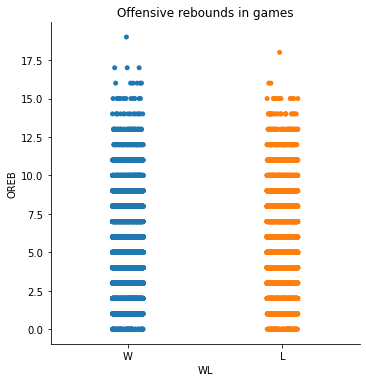

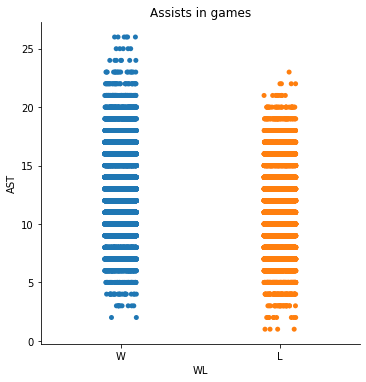

In [154]:
sns.catplot(data = df_boxscore_subset, x = "WL", y = "OREB")
plt.title("Offensive rebounds in games")
plt.show()
sns.catplot(data = df_boxscore_subset, x = "WL", y = "AST")
plt.title("Assists in games")
plt.show()

From an Offensive point of view, it looks like teams who won at the end of games, had a better performance in both categories. Slightly better in terms of rebounds but when looking at assists, the difference is a bit more obviouse.

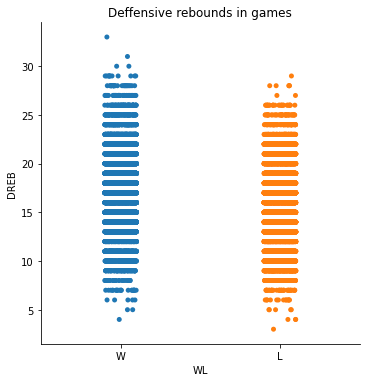

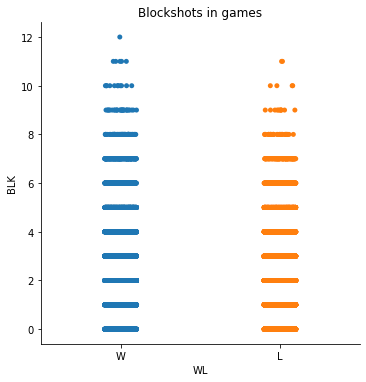

In [155]:
sns.catplot(data = df_boxscore_subset, x = "WL", y = "DREB")
plt.title("Deffensive rebounds in games")
plt.show()
sns.catplot(data = df_boxscore_subset, x = "WL", y = "BLK")
plt.title("Blockshots in games")
plt.show()

And again, from defensive point of view. Teams with a winning outcome did obtain more defensive rebounds and performed more blockshots. Now finally we are going to look at the number of turnovers done in games.

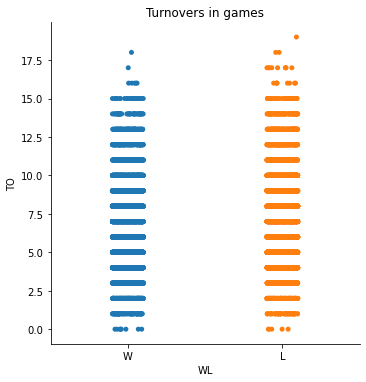

In [156]:
sns.catplot(data = df_boxscore_subset, x = "WL", y = "TO")
plt.title("Turnovers in games")
plt.show()

Since turnovers is the fact that a team looses the ball to the opposition, teams that lost generally have committed more turnovers in the first half of the game.

## Building The Model: Random Forest Classifier

In this section, we are going to build the model that predicts the outcome of a game. We are going to use Random Forest Classifier. But before we start, let's explain in how Random Forest works.

Random Forest is a supervised machine learning algorithm. And can be used as a classifier or as a regressor. What it does basically is create an ensemble of decision trees and use their output to get an output. First, it creates a bootstrap of the dataset, by randomly selecting samples from the dataset. Then, it constructs a decision tree using the bootstrap dataset by using a random subset of the variables and randomly selecting the root of the tree. These steps are repeated to create multiple trees (100 in our case). Once new data are fed to the model, the data enters the decision tree and prediction happens based on a voting process. The final outcome is based on the most votes. 

Now that we have our data subset ready, let's split the data into a training and test set.

In [121]:
# Creating the independant variable X
X =df_boxscore_subset.loc[:,"FGA":"TEAM_ABBREVIATION_WAS"]
# Creating the dependant variable Y
y = df_boxscore_subset["WL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [122]:
# Building the model
rf_classifier = RandomForestClassifier(random_state=1, n_estimators=100)
# training the model
rf_classifier = rf_classifier.fit(X_train, y_train)

### Evaluating The Model: Random Forest Classifier

Now that our model is ready, let's predict the outcome of a game with our test set and evaluate our model by looking at the confusion matrix and the classificatio report.

In [123]:
y_test_p = rf_classifier.predict(X_test)

In [124]:
rf_classifier.classes_

array(['L', 'W'], dtype=object)

In [125]:
cm = confusion_matrix(y_test, y_test_p)
cm = pd.DataFrame(cm, index = ["Loss (Actual)", "Win (Actual)"], columns= ["Loss (Predicted)", "Win (Predicted)"])
cm

,Loss (Predicted),Win (Predicted)
Loss (Actual),2362,851
Win (Actual),983,2299


What the confusion matrix tells us here is that our model predicted 2352 Loss that were actually a Loss and predicted 861 Win that were actually a Loss. Also, our model predicted 2315 Win that were actually a Win and 967 game that were actually a win were predicted as a Loss by our model.

In [126]:
print(classification_report(y_test, y_test_p))

              precision    recall  f1-score   support

           L       0.71      0.74      0.72      3213
           W       0.73      0.70      0.71      3282

    accuracy                           0.72      6495
   macro avg       0.72      0.72      0.72      6495
weighted avg       0.72      0.72      0.72      6495



By looking at the classication report we conclude the following:
* Our model has a accuracy/score of 0.72 for Loss and 0.71 for Win.
* Our model has a precision value of 0.71 for Loss predictions and 0.73 for win predictions. To put it in plain words, Out of the predicted Loss outcomes for example, 71% of the predicted loss are actual loss. Same thing goes out to Win outcome.
* Our model has a recall value of 0.74 for Loss predictions and 0.70 for win predictions. For simple explination purposes, 73% of the actual loss are predicted as loss, while 70% of the actual wins are predicted as wins by the model.

Overall, the results are good from Random Forest Classifier, but yet needs some later improvement.

## Building the model: KNN Algorithm

We tried the Random Forest Classifier algorithm for our dataset and it gave relatively good results. But now we are going to try to use K-Nearest Neighbor algorithm and see if it fits our model better than RF.

Before we delve into the application part, we are goint to explain how KNN classifier works in few steps.
* Step 1: We choose the K-Neighbours, usually we define K.
* Step 2: The new data point takes the K nearest neighbors and measures the distance to those neighbors. Usually it is the Eucledean distance.
* Step 3 : Among these neighbors, the algorithm counts the number of data point in each category.
* Step 4: the algorithm assigns the new data point to the category with most neighbors.

Now let's try to build the model by using 7 as number of neighbors.

In [127]:
# building the model with 7 neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=7)
# training the model
knn_classifier = knn_classifier.fit(X_train, y_train)

### Evaluating the model: KNN Classifier

In [128]:
y_test_p = knn_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_test_p)
cm = pd.DataFrame(cm, index = ["Loss (Actual)", "Win (Actual)"], columns= ["Loss (Predicted)", "Win (Predicted)"])
cm

,Loss (Predicted),Win (Predicted)
Loss (Actual),2213,1000
Win (Actual),1081,2201


What the confusion matrix tells us here is that 2216 Predicted Loss are actual Loss while 997 actual loss are predicted by the model as Wins. On the other hand, 2200 predicted Wins are actual wins while 1082 actual wins are predicted as loss by the algorithm.

In [129]:
print(classification_report(y_test, y_test_p))

              precision    recall  f1-score   support

           L       0.67      0.69      0.68      3213
           W       0.69      0.67      0.68      3282

    accuracy                           0.68      6495
   macro avg       0.68      0.68      0.68      6495
weighted avg       0.68      0.68      0.68      6495



By looking at the classification report we see the following:
* Accuracy is 0.68 for Loss and 68 for Win.
* Recall for loss is 0.69 and 0.67 for Win.
* Precision is 0.67 for Loss and 0.69 for wins.

By looking at the outcome, Random Forest seems to be the better model for our dataset. 

# Conclusion

In our notebook, we tried to build a two models that aims at improving NBA players efficiency in the games from two different perspectives. In the first part, we went for imrpoving the field goals made efficiency by predicting how many shot a player is going to make in an upcoming game. In a real world application, a team can use the model and make preperations or changes based on the outcome of the model. If the number predicted for example is low, the a team can dig in and finds out how to improve the efficiency of shots taken by those players. We hypothasized that certain features might play a role in determening how many shots a player will score in a game. Some variables showed good correlation with our dependant variable while others did not. And had a _P_ value higher than what would be acceptable (eg. a player's age). In the second part, we tried to create a model and predict an outcome of a game based on historic half-time data from previous games. We hypothasized that with the abundance of data available, we tried to figure a pattern in games from halftime data that might influence a game outcome. Of course, certain problems and limitation are present. Although the API proved to be robust, but when trying to fetch big amount of data from endpoints then the server shuts the requester down. We tried to tackle overfitting of the model by using large datasets so the model is better trained. Many improvements can be made on the model, adding variables to the second part such as players on every team might make the model outcome more accurate and closer to real life outcome than just a computed result. 

#### References

Emerick, P. (2017, September 30). NBA All-Out-Of Position Team. Bleacher Report. 
<a href="https://bleacherreport.com/articles/1208965-nba-all-out-of-position-team"> https://bleacherreport.com/articles/1208965-nba-all-out-of-position-team</a>

Riches, C. (2013, December 12). Changing Playing Positions. Functional Basketball Coaching.
<a href="https://functionalbasketballcoaching.com/changing-basketball-playing-positions/"> https://functionalbasketballcoaching.com/changing-basketball-playing-positions/</a>

Harvardsports, B. (2017, November 21). What Happens to NBA Players When They Age? The Harvard Sports Analysis Collective.  
<a href="http://harvardsportsanalysis.org/2017/11/what-happens-to-nba-players-when-they-age/"> http://harvardsportsanalysis.org/2017/11/what-happens-to-nba-players-when-they-age/</a>

Players statistics of the FIBA Intercontinental Cup 2020. (2020). FIBA.Basketball. 
<a href="https://www.fiba.basketball/intercontinentalcup/2020/playerstats"> https://www.fiba.basketball/intercontinentalcup/2020/playerstats</a>

Ross, T. F. (2015, June 25). The Rise of Data Analysis Is Changing the NBA. The Atlantic. 
<a href="https://www.theatlantic.com/entertainment/archive/2015/06/nba-data-analytics/396776/"> https://www.theatlantic.com/entertainment/archive/2015/06/nba-data-analytics/396776/</a>